# Summary of work

- Analyzed and processed the data for easy modeling (Data will be processed according to *hours* frame)
- Used FPT, MSN, VIC as training data, and PNJ as test data.
- Used data from the last 10 hours, represented by X with 5 attributes (`Open`, `High`, `Low`, `Close`, `Volume`), to predict Y, the next closing price. X has a shape of (1, 50), and Y has a shape of (1, 1).
- Utilized machine learning models (`Linear Regression`, `Decision Tree Regressor`, `RandomForest Regressor`) and deep learning models (`Neural Network`, `RNN`, `LSTM`, `Transformer`).
- Selected the best-performing model and predicted `Stock Price Volatility` = `Stock Price N (hours) later` - `Current stock price`

# A. Import libraries and set up parameter

### 1. Import Lib

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

### 2. Parameter

In [78]:
WINDOW_SIZE = 11 # 10 PERIODS OF TIME FOR VARIABLE X + 1 PERIOD FOR Y
INPUT_DIM = 50 # 5 ATTRIBUTES * 10 PERIODS OF TIME X
OUTPUT_DIM = 1 # THE FUTURE CLOSE PRICE
NUM_LAYERS = 4
HIDDEN_DIM = 64

# ====================================
# DATA PATH
DATA_DIR = "./data/"
DATA_FPT_PATH = DATA_DIR+"FPT.csv"
DATA_MSN_PATH = DATA_DIR+"MSN.csv"
DATA_PNJ_PATH = DATA_DIR+"PNJ.csv"
DATA_VIC_PATH = DATA_DIR+"VIC.csv"

# ====================================
# SAVE MODELS
MODEL_DIR = "./results/"

#=====================================
# TRAINING
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.02

# =====================================
# DEVICE CONFIGURATION
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cuda')

# B. Prepare Data

### 0. Analyze and visualize data

In [17]:
df_FPT = pd.read_csv(DATA_FPT_PATH)
df_MSN = pd.read_csv(DATA_MSN_PATH)
df_PNJ = pd.read_csv(DATA_PNJ_PATH)
df_VIC = pd.read_csv(DATA_VIC_PATH)

In [5]:
print(df_FPT.head())
print(df_MSN.head())
print(df_PNJ.head())
print(df_VIC.head())

  Ticker        Date/Time   Open   High    Low  Close  Volume  Open Interest
0    FPT  12/25/2018 9:15  30.89  30.89  30.89  30.89   35410              0
1    FPT  12/25/2018 9:16  30.81  30.81  30.81  30.81     190              0
2    FPT  12/25/2018 9:17  30.74  30.81  30.74  30.74    1120              0
3    FPT  12/25/2018 9:18  30.74  30.74  30.74  30.74    2120              0
4    FPT  12/25/2018 9:19  30.74  30.74  30.74  30.74   22500              0
  Ticker        Date/Time  Open  High   Low  Close  Volume  Open Interest
0    MSN  12/25/2017 9:15  73.1  73.1  73.1   73.1    4210              0
1    MSN  12/25/2017 9:16  73.0  73.0  73.0   73.0    5000              0
2    MSN  12/25/2017 9:18  73.5  73.5  73.5   73.5     210              0
3    MSN  12/25/2017 9:20  73.2  73.5  73.1   73.1    2050              0
4    MSN  12/25/2017 9:21  73.0  73.0  73.0   73.0    1380              0
  Ticker       Date/Time   Open   High    Low  Close  Volume  Open Interest
0    PNJ  2/28/201

**Noted:**
- Data is collected at a 1-minute timeframe (`1m`).
- Start and end time at each stock so different
- Data `Date/Time` (ex:12/25/2018 9:15) not suitable for sorting and indexing so I will transform it to `%Y%m%d%H` format


In [20]:
def process_date_time(df):
    # Convert 'Date/Time' to datetime format
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

    # Rename 'Date/Time' to 'Minus' and format it
    df['Minus'] = df['Date/Time'].dt.strftime('%Y%m%d%H%M')

    # Extract 'Hours' and 'Days'
    df["Hours"] = df['Date/Time'].dt.strftime('%Y%m%d%H')
    df["Days"] = df['Date/Time'].dt.strftime('%Y%m%d')

    # Reorder columns
    df = df[['Minus', 'Hours', 'Days', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Open Interest']]
    # Sort DataFrame by 'Minus', 'Ticker'
    df = df.sort_values(['Minus', 'Ticker'], ascending = [True, True])

    return df


In [18]:
df_FPT = process_date_time(df_FPT)
df_MSN = process_date_time(df_MSN)
df_PNJ = process_date_time(df_PNJ)
df_VIC = process_date_time(df_VIC)

In [19]:
df_FPT.head()

,Minus,Hours,Days,Open,High,Low,Close,Volume,Ticker,Open Interest
0,201812250915,2018122509,20181225,30.89,30.89,30.89,30.89,35410,FPT,0
1,201812250916,2018122509,20181225,30.81,30.81,30.81,30.81,190,FPT,0
2,201812250917,2018122509,20181225,30.74,30.81,30.74,30.74,1120,FPT,0
3,201812250918,2018122509,20181225,30.74,30.74,30.74,30.74,2120,FPT,0
4,201812250919,2018122509,20181225,30.74,30.74,30.74,30.74,22500,FPT,0


In [6]:
print(df_FPT['Open Interest'].value_counts())
print(df_MSN['Open Interest'].value_counts())
print(df_PNJ['Open Interest'].value_counts())
print(df_VIC['Open Interest'].value_counts())

Open Interest
0    97406
Name: count, dtype: int64
Open Interest
0    135354
Name: count, dtype: int64
Open Interest
0    125309
Name: count, dtype: int64
Open Interest
0    101266
Name: count, dtype: int64


**noted:**
- The `Open Interest` attribute just contains Zero (0) value so I will remove it, and `Ticker` will be removed because it does not necessary
- In this project, I will process data with hours frame by computing `mean` of minus data

In [21]:
def groupby_hours_df(df):
    df.set_index('Hours', inplace=True) 
    df = df.groupby(df.index)[['Open', 'High', 'Low', 'Close', 'Volume']].mean()
    return df

In [22]:
df_FPT = groupby_hours_df(df_FPT)
df_MSN = groupby_hours_df(df_MSN)
df_PNJ = groupby_hours_df(df_PNJ)
df_VIC = groupby_hours_df(df_VIC)

In [23]:
df_FPT

,Open,High,Low,Close,Volume
Hours,,,,,
2018122509,30.760000,30.781429,30.744286,30.760000,12137.142857
2018122609,31.055714,31.065357,31.047500,31.057143,1783.928571
2018122610,31.121842,31.125789,31.116579,31.121579,2508.684211
2018122611,31.036875,31.046250,31.034375,31.046250,2331.250000
2018122613,30.993200,31.002800,30.993200,31.002800,2451.200000
...,...,...,...,...,...
2020122209,57.468889,57.486667,57.440000,57.453333,7560.888889
2020122210,57.393333,57.413333,57.368333,57.393333,5966.833333
2020122211,57.507143,57.532143,57.471429,57.507143,12836.428571


- **This is finally data after processing**

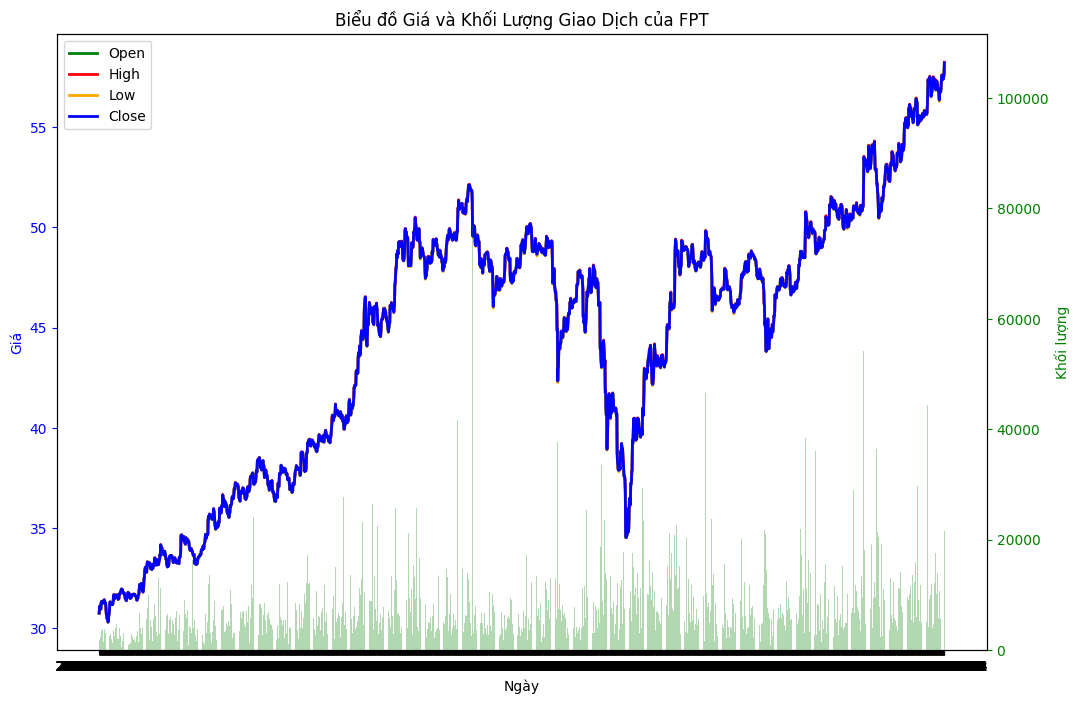

In [32]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df_FPT.index.to_numpy(), df_FPT['Open'].to_numpy(), label='Open', linewidth=2, color='green')
ax1.plot(df_FPT.index.to_numpy(), df_FPT['High'].to_numpy(), label='High', linewidth=2, color='red')
ax1.plot(df_FPT.index.to_numpy(), df_FPT['Low'].to_numpy(), label='Low', linewidth=2, color='orange')
ax1.plot(df_FPT.index.to_numpy(), df_FPT['Close'].to_numpy(), label='Close', linewidth=2, color='blue')
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Giá', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(df_FPT.index.to_numpy(), df_FPT['Volume'], label='Volume', alpha=0.3, color='green')
ax2.set_ylabel('Khối lượng', color='green')
ax2.tick_params('y', colors='green')
plt.title('Biểu đồ Giá và Khối Lượng Giao Dịch của FPT')
plt.show()

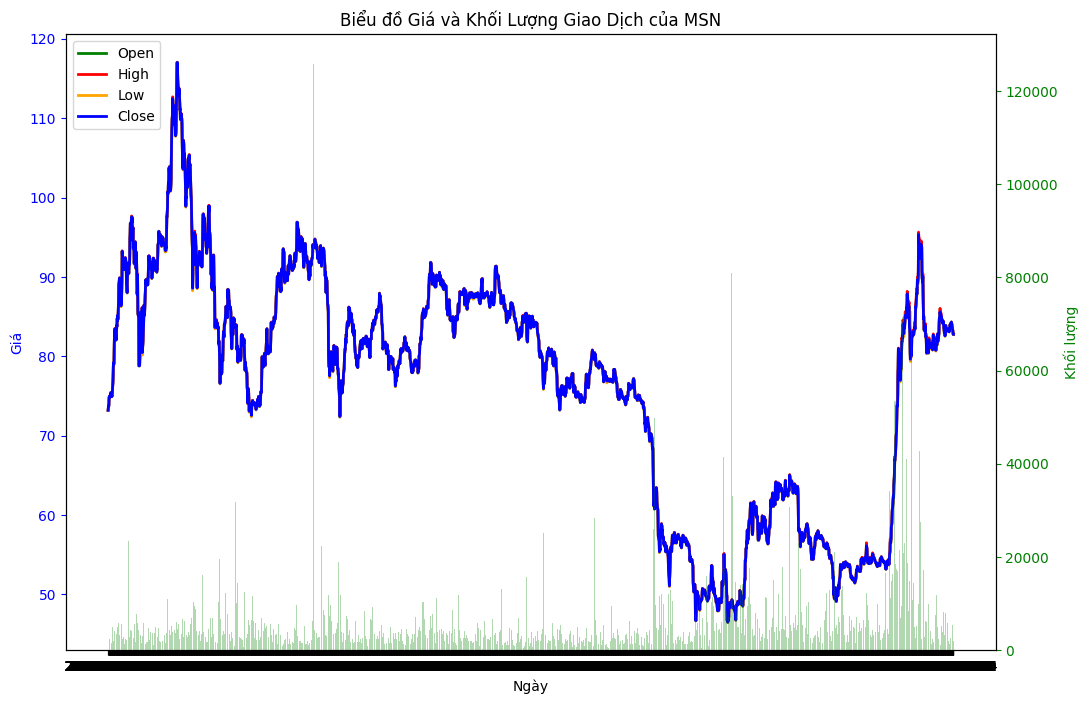

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df_MSN.index.to_numpy(), df_MSN['Open'].to_numpy(), label='Open', linewidth=2, color='green')
ax1.plot(df_MSN.index.to_numpy(), df_MSN['High'].to_numpy(), label='High', linewidth=2, color='red')
ax1.plot(df_MSN.index.to_numpy(), df_MSN['Low'].to_numpy(), label='Low', linewidth=2, color='orange')
ax1.plot(df_MSN.index.to_numpy(), df_MSN['Close'].to_numpy(), label='Close', linewidth=2, color='blue')
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Giá', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(df_MSN.index.to_numpy(), df_MSN['Volume'], label='Volume', alpha=0.3, color='green')
ax2.set_ylabel('Khối lượng', color='green')
ax2.tick_params('y', colors='green')

plt.title('Biểu đồ Giá và Khối Lượng Giao Dịch của MSN')
plt.show()

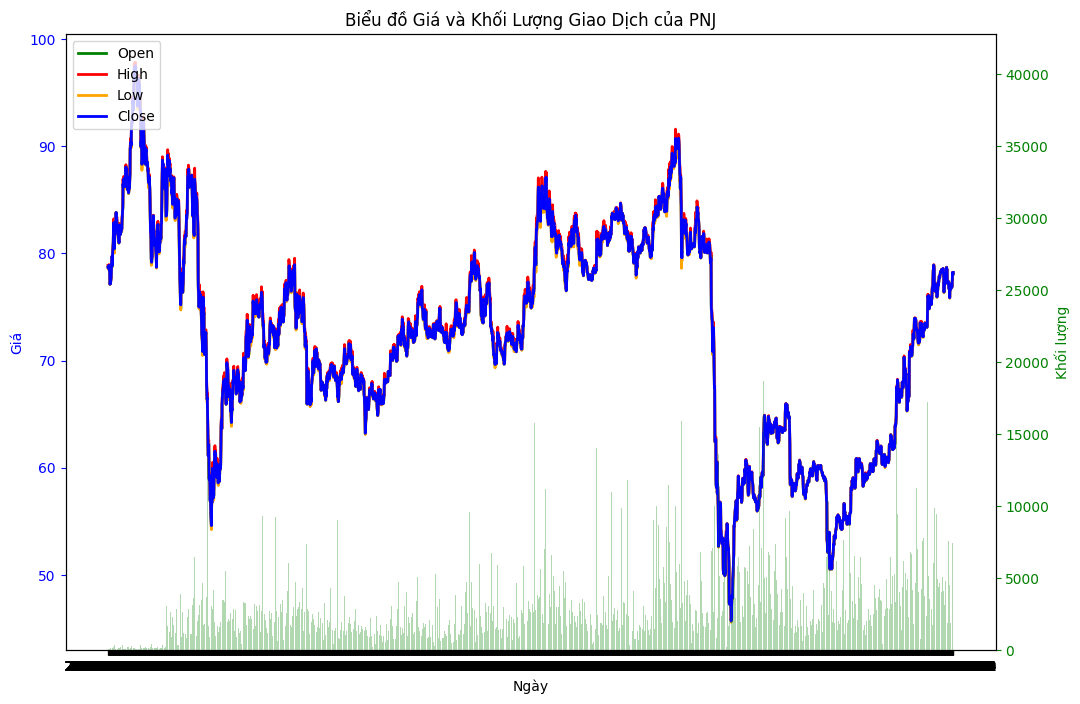

In [34]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df_PNJ.index.to_numpy(), df_PNJ['Open'].to_numpy(), label='Open', linewidth=2, color='green')
ax1.plot(df_PNJ.index.to_numpy(), df_PNJ['High'].to_numpy(), label='High', linewidth=2, color='red')
ax1.plot(df_PNJ.index.to_numpy(), df_PNJ['Low'].to_numpy(), label='Low', linewidth=2, color='orange')
ax1.plot(df_PNJ.index.to_numpy(), df_PNJ['Close'].to_numpy(), label='Close', linewidth=2, color='blue')
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Giá', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(df_PNJ.index.to_numpy(), df_PNJ['Volume'], label='Volume', alpha=0.3, color='green')
ax2.set_ylabel('Khối lượng', color='green')
ax2.tick_params('y', colors='green')

plt.title('Biểu đồ Giá và Khối Lượng Giao Dịch của PNJ')
plt.show()

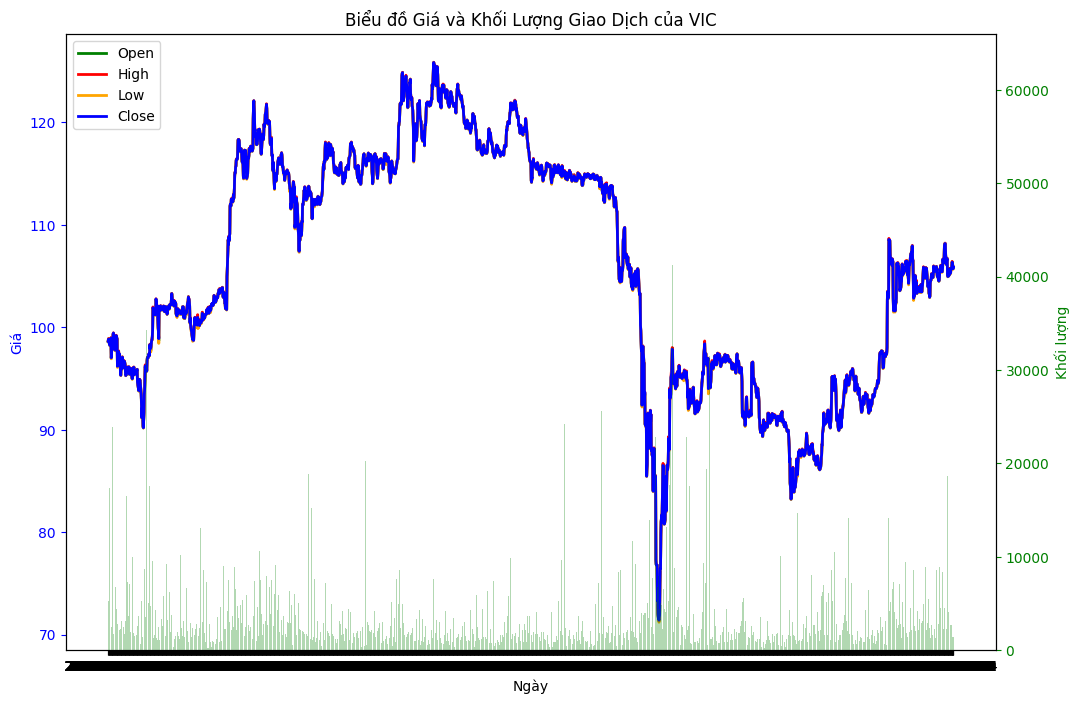

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(df_VIC.index.to_numpy(), df_VIC['Open'].to_numpy(), label='Open', linewidth=2, color='green')
ax1.plot(df_VIC.index.to_numpy(), df_VIC['High'].to_numpy(), label='High', linewidth=2, color='red')
ax1.plot(df_VIC.index.to_numpy(), df_VIC['Low'].to_numpy(), label='Low', linewidth=2, color='orange')
ax1.plot(df_VIC.index.to_numpy(), df_VIC['Close'].to_numpy(), label='Close', linewidth=2, color='blue')
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Giá', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(df_VIC.index.to_numpy(), df_VIC['Volume'], label='Volume', alpha=0.3, color='green')
ax2.set_ylabel('Khối lượng', color='green')
ax2.tick_params('y', colors='green')

plt.title('Biểu đồ Giá và Khối Lượng Giao Dịch của VIC')

plt.show()

### 1. Preprocess data

In [3]:
df_FPT = pd.read_csv(DATA_FPT_PATH)
df_MSN = pd.read_csv(DATA_MSN_PATH)
df_PNJ = pd.read_csv(DATA_PNJ_PATH)
df_VIC = pd.read_csv(DATA_VIC_PATH)

def process_date_time(df):
    # Convert 'Date/Time' to datetime format
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

    # Rename 'Date/Time' to 'Minus' and format it
    df['Minus'] = df['Date/Time'].dt.strftime('%Y%m%d%H%M')

    # Extract 'Hours' and 'Days'
    df["Hours"] = df['Date/Time'].dt.strftime('%Y%m%d%H')
    df["Days"] = df['Date/Time'].dt.strftime('%Y%m%d')

    # Reorder columns
    df = df[['Minus', 'Hours', 'Days', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Open Interest']]
    # Sort DataFrame by 'Minus', 'Ticker'
    df = df.sort_values(['Minus', 'Ticker'], ascending = [True, True])

    return df

def groupby_hours_df(df):
    df.set_index('Hours', inplace=True) 
    df = df.groupby(df.index)[['Open', 'High', 'Low', 'Close', 'Volume']].mean()
    return df

df_FPT = process_date_time(df_FPT)
df_MSN = process_date_time(df_MSN)
df_PNJ = process_date_time(df_PNJ)
df_VIC = process_date_time(df_VIC)

df_FPT = groupby_hours_df(df_FPT)
df_MSN = groupby_hours_df(df_MSN)
df_PNJ = groupby_hours_df(df_PNJ)
df_VIC = groupby_hours_df(df_VIC)

### Data Scaling

In [6]:
## concat all of close data
df_close = pd.concat([df_FPT[['Close']], df_MSN[['Close']], df_PNJ[['Close']], df_VIC[['Close']]], axis=0)

In [7]:
df_close.min(), df_close.max()

(Close    30.314324
 dtype: float64,
 Close    125.853659
 dtype: float64)

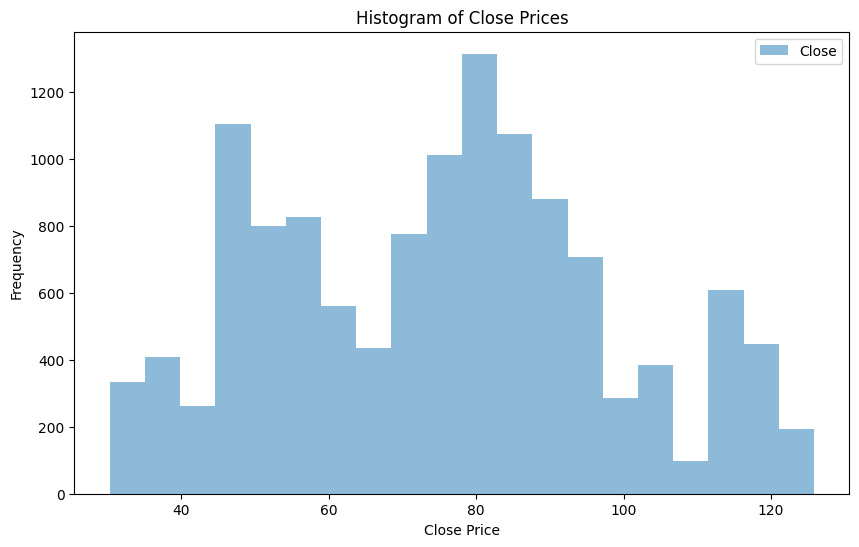

In [90]:
# Plot histogram
df_close.plot.hist(alpha=0.5, bins=20, figsize=(10, 6), title='Histogram of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

**Note:**
-  The data's closing price range is within (30, 130), with the most frequent values centered around 80.
-   In the context of the problem, a challenge is presented in scaling the Close Price values to the range (0, 1). Traditional scaling methods like MinMaxScaling seem inappropriate, especially considering stock prices may exceed 130
-   I propose scaling using the `sigmoid function`

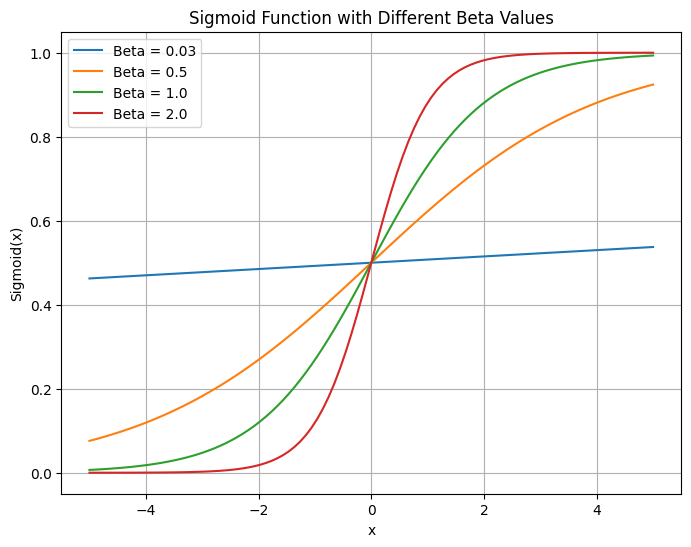

In [8]:
# The plot illustrates the Sigmoid function with varying beta values, showcasing the impact on the curve's steepness.
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, beta=1.0):
    return 1 / (1 + np.exp(-beta * x))

# X value
x = np.linspace(-5, 5, 100)

# beta values
beta_values = [0.5, 1.0, 2.0]

plt.figure(figsize=(8, 6))

for beta in beta_values:
    y = sigmoid(x, beta)
    plt.plot(x, y, label=f'Beta = {beta}')

plt.title('Sigmoid Function with Different Beta Values')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.legend()
plt.grid(True)
plt.show()


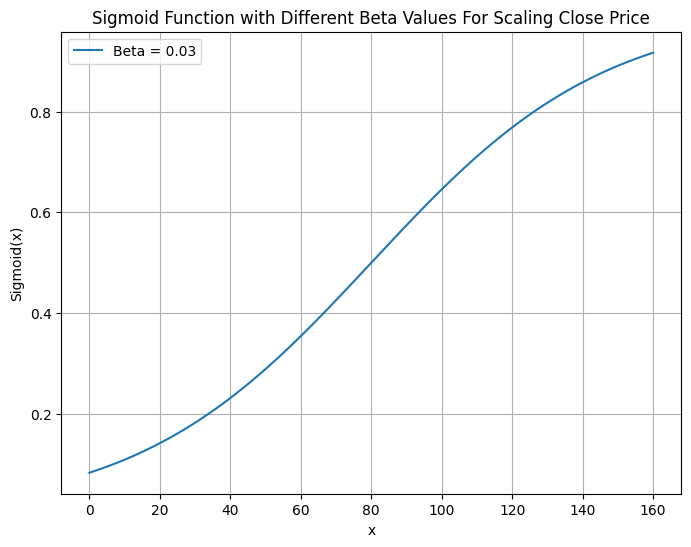

In [10]:
def sigmoid(x, beta= 0.03):
    return 1 / (1 + np.exp(-beta * (x-80)))

x = np.linspace(0, 160, 1000)


plt.figure(figsize=(8, 6))
y = sigmoid(x)
plt.plot(x, y, label=f'Beta = {0.03}')

plt.title('Sigmoid Function with Different Beta Values For Scaling Close Price')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.legend()
plt.grid(True)
plt.show()


- The sigmoid function effectively maps the original range of close prices (0 to 160) to a probability distribution between 0 and 1. In this case, the midpoint of the sigmoid curve aligns with the average close price of 80.

### 2. Dataset Class
Class are used to create and manage training data during machine learning model training.

In [94]:
def sigmoid(x, beta= 0.03):
    return 1 / (1 + np.exp(-beta * (x-80)))

def reverse_sigmoid(y, beta=0.03):
    # Use the inverse formula of sigmoid to reverse the transformation
    return 80 + np.log(y / (1 - y)) / beta


class TrainingDatasetDL(Dataset):
    def __init__(self, df, window_size=11):
        self.data = df
        self.seq_len  = window_size
        self.index = self.data.index.unique()
    
    def __len__(self):
        return len(self.index)-1
    
    def __getitem__(self, idx_time):
        d_x = idx_time - self.seq_len + 1
        d_y = idx_time
        X = self.data.loc[self.index[d_x:idx_time]]
        if X.empty:
            X = np.zeros((1, (self.seq_len-1)*5)).reshape(1,-1)
            return X , np.array([0])
        
        data_y = self.data.loc[self.index[d_y:idx_time + 1]]
        y = data_y.Close.values
        
        return np.array(X).reshape(1,-1), sigmoid(y)
    
    def __iter__(self):
        self.current_index = 10
        return self

    def __next__(self):
        if self.current_index < len(self.index):
            result = self[self.current_index]
            self.current_index += 1
            return result
        else:
            raise StopIteration

class TrainingDatasetML(Dataset):
    def __init__(self, df, window_size=11):
        self.data = df
        self.seq_len  = window_size
        self.index = self.data.index.unique()
    
    def __len__(self):
        return len(self.index)-1
    
    def __getitem__(self, idx_time):
        d_x = idx_time - self.seq_len + 1
        d_y = idx_time
        X = self.data.loc[self.index[d_x:idx_time]]
        if X.empty:
            X = np.zeros((1, (self.seq_len-1)*5)).reshape(1,-1)
            return X , np.array([0])
        
        data_y = self.data.loc[self.index[d_y:idx_time + 1]]
        y = data_y.Close.values
        
        return np.array(X).reshape(1,-1), y
    
    def __iter__(self):
        self.current_index = 10
        return self

    def __next__(self):
        if self.current_index < len(self.index):
            result = self[self.current_index]
            self.current_index += 1
            return result
        else:
            raise StopIteration


# C. Build model Machine learning

### 1. Prepare training and testing data

In [194]:
data_FPT = TrainingDatasetML(df_FPT)
data_MSN = TrainingDatasetML(df_MSN)
data_VIC = TrainingDatasetML(df_VIC)
data_PNJ = TrainingDatasetML(df_PNJ)

**Used FPT, MSN, VIC as training data, and PNJ as test data.**

In [101]:
# Create X_train, y_train
X_train, y_train =[],[]
iteration = iter(data_FPT)
for i in range(len(data_FPT)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break

iteration = iter(data_MSN)
for i in range(len(data_MSN)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break
    
iteration = iter(data_VIC)
for i in range(len(data_VIC)):
    try:
        X_value, y_value = next(iteration)
        X_train.append(X_value)
        y_train.append(y_value)
    except:
        break

X_train = np.array(X_train).reshape(-1,50)
y_train = np.array(y_train).reshape(-1,1)

In [195]:
### Create X_test, Y test
X_test, y_test =[],[]
iteration = iter(data_PNJ)
for i in range(len(data_PNJ)):
    try:
        X_value, y_value = next(iteration)
        X_test.append(X_value)
        y_test.append(y_value)
    except:
        break


X_test = np.array(X_test).reshape(-1,50)
y_test = np.array(y_test).reshape(-1,1)

In [103]:
print("Training set shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nTest set shapes:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training set shapes:
X_train shape: (8934, 50)
y_train shape: (8934, 1)

Test set shapes:
X_test shape: (3533, 50)
y_test shape: (3533, 1)


### 2. Linear Regression Model

In [105]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [114]:
# Save model
joblib.dump(linear_model, f'{MODEL_DIR}linear_model.joblib')

['./results/linear_model.joblib']

### 3. DecisionTreeRegressor Model


In [130]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [117]:
# Save model
joblib.dump(tree_model, f'{MODEL_DIR}tree_model.joblib')

['./results/tree_model.joblib']

### 4. RandomForestRegressor Model

In [111]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train.ravel())

RandomForestRegressor()

In [118]:
# Save model
joblib.dump(forest_model, f'{MODEL_DIR}forest_model.joblib')

['./results/forest_model.joblib']

# D. Build model deep learning

### 1. Prepare training and testing data

In [91]:
data_FPT = TrainingDatasetDL(df_FPT)
data_MSN = TrainingDatasetDL(df_MSN)
data_VIC = TrainingDatasetDL(df_VIC)
data_PNJ = TrainingDatasetDL(df_PNJ)
# Combine training datasets into one
train_datasets = ConcatDataset([data_FPT, data_MSN, data_VIC])

# Create DataLoader for training datasets
train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=False)

# Create DataLoader for the test dataset
test_loader = DataLoader(data_PNJ, batch_size=1, shuffle=False)

### 2. Neural Network

In [127]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()

        # Define the first hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        # Define the second hidden layer
        self.fc2 = nn.Linear(256, 64)
        
        # Define the third hidden layer
        self.fc3 = nn.Linear(64, 16)

        # Define the output layer
        self.fc4 = nn.Linear(16, output_dim)

    def forward(self, x):
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Fully connected layer 3
        x = self.fc3(x)
        x = self.relu(x)

        # Output layer
        x = self.fc4(x)
        return x

In [128]:
# Create an instance of the model
model_nn = NeuralNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

# Move the model to the specified device (cuda or cpu)
model_nn = model_nn.to(DEVICE)

# Criterion (Loss function)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model_nn.parameters(), lr=0.1)

In [24]:

# Training loop
start_time = time.time()

loss_model_nn_values = []

for epoch in range(EPOCHS):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for input_batch, target_batch in progress_bar:
        # Move input and target data to the specified device
        input_batch, target_batch = input_batch.to(DEVICE), target_batch.to(DEVICE)
       

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model_nn(input_batch.float())

        # Calculate loss
        loss = criterion(output, target_batch.float())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix({"Average Loss:": total_loss / len(train_loader),"Total Loss:": total_loss })

    loss_model_nn_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        # print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_nn.state_dict(), "results2/model_nn.pth")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 1/100:   0%|          | 0/71 [00:00<?, ?it/s]

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  99%|█████████▊| 70/71 [00:08<00:00,  9.11it/s, Average Loss:=4.32e+5, Total Loss:=3.07e+7]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 100/100: 100%|██████████| 71/71 [00:17<00:00,  4.13it/s, Average Loss:=0.0333, Total Loss:=2.36]   

Training time: 1106.31 seconds


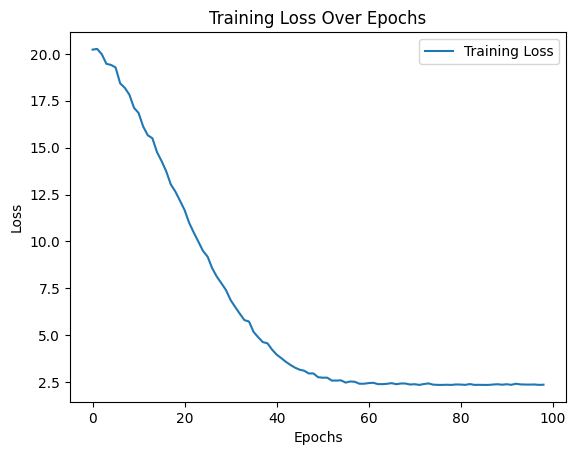

In [26]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_nn_values[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 3.RNN

In [121]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device):
        super(RNN, self).__init__()
        # Hidden dimension
        self.hidden_dim = hidden_dim
        
        self.device = device

        # Number of hidden layers
        self.layer_dim = num_layers

        # Recurrent layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='relu').to(self.device)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)

        # Forward propagate RNN
        out, hn = self.rnn(x, h0.detach())

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

In [125]:
model_rnn = RNN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM , num_layers=NUM_LAYERS, device=DEVICE)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model_rnn.parameters(), lr=0.02)

In [ ]:
# Training loop
start_time = time.time()

loss_model_rnn_values = []

for epoch in range(10):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)
    model_rnn.train()  # Chuyển mô hình về chế độ đào tạo

    for x_batch, y_batch in progress_bar:
        y_train_pred = model_rnn(x_batch.float())
        loss = criterion(y_train_pred, y_batch.float())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})
        print("============PRED===============")
        print(y_train_pred.view(1,-1))
        print("============REAL===============")
        print(y_batch.view(1,-1))
    loss_model_rnn_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_rnn, "results/model_rnn.pt")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))


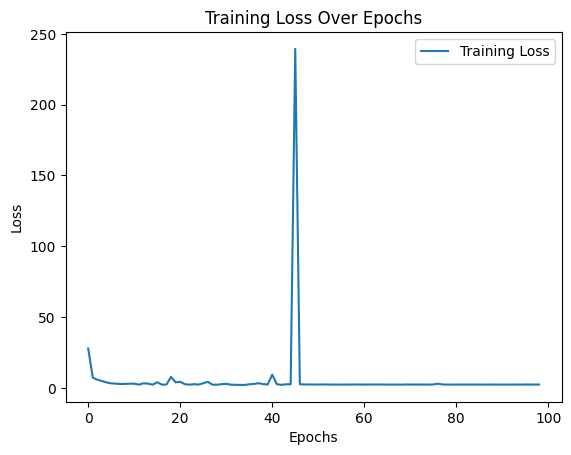

In [34]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_rnn_values[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


### 4. LSTM

In [172]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(self.device)
        self.fc = nn.Linear(hidden_dim, output_dim).to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        out, (hn, cn) = self.lstm(x.to(self.device), (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [32]:
model_LSTM = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_LSTM.parameters(), lr=0.02)

In [35]:
# Training loop
start_time = time.time()

loss_model_LSTM_values = []

for epoch in range(50):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for x_batch, y_batch in progress_bar:
        y_train_pred = model_LSTM(x_batch.float())
        loss = criterion(y_train_pred, y_batch.float())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})

    loss_model_LSTM_values.append(total_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_LSTM, "results/model_lstm.pt")

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 10/100: 100%|██████████| 71/71 [00:11<00:00,  6.13it/s, Loss=0.0338] 


Epoch 10, Average Loss: 0.03384092549832774


Epoch 20/100: 100%|██████████| 71/71 [00:08<00:00,  8.34it/s, Loss=0.0337] 


Epoch 20, Average Loss: 0.033701765573990176


Epoch 30/100: 100%|██████████| 71/71 [00:10<00:00,  6.46it/s, Loss=0.0331] 


Epoch 30, Average Loss: 0.03306307541337651


Epoch 40/100: 100%|██████████| 71/71 [00:09<00:00,  7.34it/s, Loss=0.0327] 


Epoch 40, Average Loss: 0.03271454766812459


Epoch 50/100: 100%|██████████| 71/71 [00:09<00:00,  7.87it/s, Loss=0.033]  

Epoch 50, Average Loss: 0.03298203012263271
Training time: 531.04 seconds


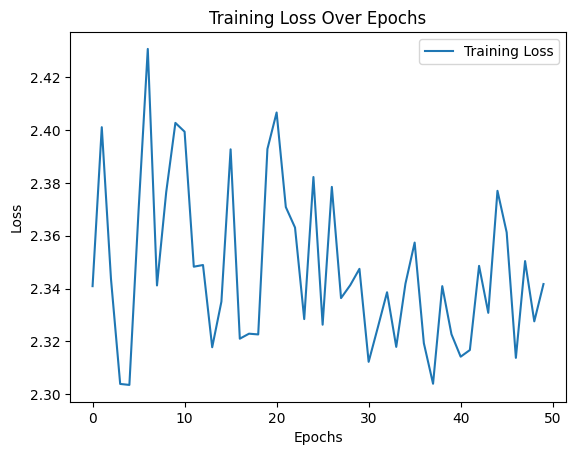

In [36]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_LSTM_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 5. Transformer

In [174]:
D_MODEL = 256
NHEAD = 8
DROPOUT= 0.2

In [175]:
class StockPriceTransformer(nn.Module):
    def __init__(self, input_dim,  d_model, nhead, num_layers, dropout, output_dim):
        super(StockPriceTransformer, self).__init__()
        self.input_linear_en = nn.Linear(input_dim, d_model)
        self.input_linear_de = nn.Linear(1, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, dropout=dropout)
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt):
        src = self.input_linear_en(src)
        tgt = self.input_linear_de(tgt)
        output = self.transformer(src, tgt)
        output = self.output_linear(output)
        return output

model_transformer = StockPriceTransformer(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM,d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=LEARNING_RATE)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [39]:
# Training loop
start_time = time.time()
loss_model_transformer_LSTM_values = []

for epoch in range(50):
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for src_batch, tgt_batch in progress_bar:
        optimizer.zero_grad()
        # print(src_batch.shape, tgt_batch.unsqueeze(dim=1).shape)
        output = model_transformer(src_batch.float(), tgt_batch.unsqueeze(dim=1).float())
        
        loss = criterion(output, tgt_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        progress_bar.set_postfix({"Loss": total_loss / len(train_loader)})
        
    loss_model_transformer_LSTM_values.append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(train_loader)}")
        torch.save(model_transformer, "results/model_transformer.pt")

Epoch 1/100:   0%|          | 0/71 [00:00<?, ?it/s]c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  99%|█████████▊| 70/71 [01:02<00:00,  1.31it/s, Loss=75.3]  c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/100: 100%|██████████| 71/71 [00:53<00:00,  1.32it/s, Loss=0.0448] 


Epoch 10, Average Loss: 0.04476251668283637


Epoch 20/100: 100%|██████████| 71/71 [00:43<00:00,  1.63it/s, Loss=0.039]  


Epoch 20, Average Loss: 0.03896614107197564


Epoch 30/100: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s, Loss=0.0548]


Epoch 30, Average Loss: 0.054804902576224904


Epoch 40/100: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s, Loss=0.039]  


Epoch 40, Average Loss: 0.03898748469499635


Epoch 50/100: 100%|██████████| 71/71 [00:47<00:00,  1.51it/s, Loss=0.0362] 

Epoch 50, Average Loss: 0.0362268809858762


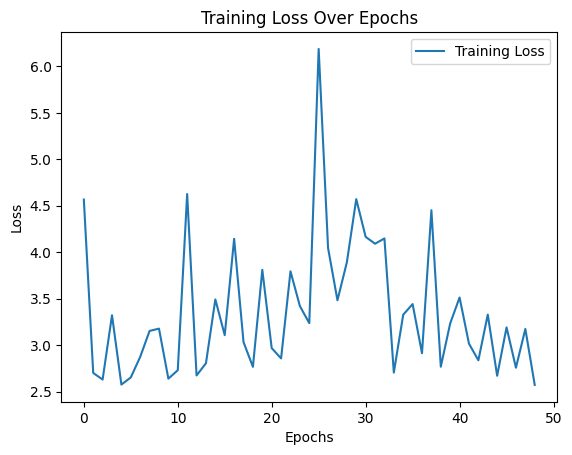

In [42]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.plot(loss_model_transformer_LSTM_values[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# E. Load model and prediction

In [176]:
def predict(model, dataloader):
    predictions = []
    # Iterate through the test DataLoader
    for input_batch, target_batch in dataloader:
        input_batch = input_batch.to(DEVICE)
        output = model(input_batch.float())
        # print(output)
        output2 = output.view(-1).detach().numpy()
        predictions.append(output2)
    
    # Concatenate predictions into a single numpy array
    predictions = np.concatenate(predictions, axis=0)
    
    return predictions

def predict_transfomer(model, dataloader):
    predictions = []
    # Iterate through the test DataLoader
    for input_batch, _ in dataloader:
        input_batch = input_batch.to(DEVICE)
        target_batch = torch.zeros(input_batch.shape[0], 1, 1)
        output = model(input_batch.float(), target_batch.float())
        output = output.view(-1).detach().numpy()
        predictions.append(output)
    
    # Concatenate predictions into a single numpy array
    predictions = np.concatenate(predictions, axis=0)
    
    return predictions

def labels_data(test_loader):
    y_test_list = []

    for _, target_batch in test_loader:
        y_test = target_batch.view(-1).detach().numpy()
        
        y_test_list.append(y_test)

    # Concatenate the list of numpy arrays into a single numpy array
    y_real = np.concatenate(y_test_list, axis=0)
    return reverse_sigmoid(y_real)

In [167]:
# load model Neural network
model_nn = NeuralNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
# Load the pre-trained weights
model_nn.load_state_dict(torch.load("results/model_nn.pth"))
# Put the model in evaluation mode
model_nn.eval()
# Use the predict function to get predictions on the test data
nn_pred_values = reverse_sigmoid(predict(model_nn, test_loader))

In [168]:
# load model RNN
model_rnn = RNN(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)

# Load the entire model
model_rnn = torch.load("results/model_rnn.pt", map_location=DEVICE)

# # Put the model in evaluation mode
model_rnn.eval()

# Use the predict function to get predictions on the test data
rnn_pred_values = reverse_sigmoid(predict(model_rnn, test_loader))

In [177]:
# load model lstm
model_lstm = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS, device=DEVICE)

# Load the entire model
model_lstm = torch.load("results/model_lstm.pt", map_location=DEVICE)

# Put the model in evaluation mode
model_lstm.eval()

# Use the predict function to get predictions on the test data
lstm_pred_values = reverse_sigmoid(predict(model_lstm, test_loader))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12884\3341563529.py:6: RuntimeWarning: invalid value encountered in log
  return 80 + np.log(y / (1 - y)) / beta


In [178]:
# load transformer model
model_transformer = StockPriceTransformer(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM,d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT)
model_transformer = torch.load("results/model_transformer.pt", map_location=DEVICE)
model_transformer.eval()
transformer_pred_values = reverse_sigmoid(predict_transfomer(model_transformer, test_loader))

In [196]:
# Load model
linear_model = joblib.load(f'{MODEL_DIR}linear_model.joblib')
tree_model = joblib.load(f'{MODEL_DIR}tree_model.joblib')
forest_model = joblib.load(f'{MODEL_DIR}forest_model.joblib')

linear_preds = linear_model.predict(X_test)
tree_preds = tree_model.predict(X_test)
forest_preds = forest_model.predict(X_test)

In [197]:
linear_mse = mean_squared_error(y_test, linear_preds)
tree_mse = mean_squared_error(y_test, tree_preds)
forest_mse = mean_squared_error(y_test, forest_preds)

In [204]:
y_real = labels_data(test_loader)
mse_nn = mean_squared_error(y_real[10:], nn_pred_values[10:])
mse_rnn = mean_squared_error(y_real[10:], rnn_pred_values[10:])
mse_lstm = mean_squared_error(y_real[10:], lstm_pred_values[10:])
mse_transformer = mean_squared_error(y_real[10:], transformer_pred_values[10:])

data = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Neural Network', 'RNN', 'LSTM', 'Transformer'],
    'MSE': [linear_mse, tree_mse, forest_mse, mse_nn, mse_rnn, mse_lstm, mse_transformer]
}
df_mse = pd.DataFrame(data)
df_mse

,Model,MSE
0,Linear Regression,0.432483
1,Decision Tree,2.103156
2,Random Forest,0.549208
3,Neural Network,112.203178
4,RNN,107.558902
5,LSTM,99.963672
6,Transformer,128.754779



- In general, machine learning models demonstrate better predictive performance with the given data compared to deep learning models.

- The best-performing model is Linear Regression, and I have decided to use this model for forecasting future price fluctuations.

- The deep learning models exhibit suboptimal performance and face some unresolved issues that I haven't had the time to address. Nevertheless, through this, we can observe the robust capabilities of machine learning in the financial domain.

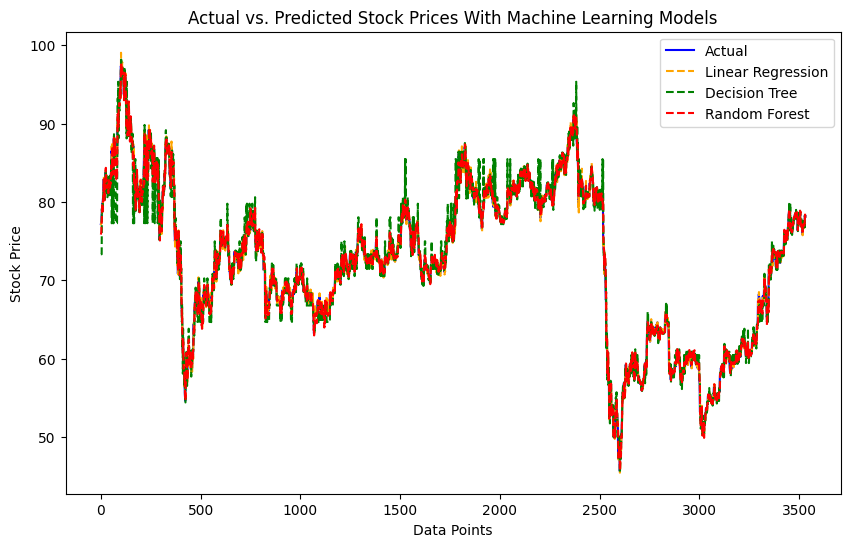

In [145]:
# Plot actual vs. predicted values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.ravel(), label='Actual', color='blue')
plt.plot(linear_preds.ravel(), label='Linear Regression', linestyle='--', color='orange')
plt.plot(tree_preds.ravel(), label='Decision Tree', linestyle='--', color='green')
plt.plot(forest_preds.ravel(), label='Random Forest', linestyle='--', color='red')
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices With Machine Learning Models')
plt.show()

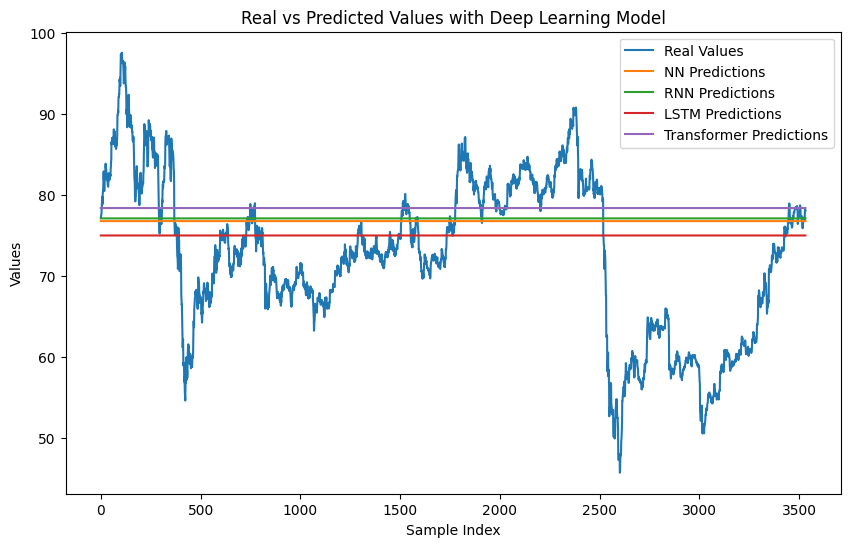

In [70]:
# Vẽ biểu đồ line cho tất cả các thuộc tính
plt.figure(figsize=(10, 6))
plt.plot(y_real[10:], label='Real Values', linestyle='-', markersize=2)
plt.plot(nn_pred_values[10:], label='NN Predictions', linestyle='-', markersize=2)
plt.plot(rnn_pred_values[10:], label='RNN Predictions', linestyle='-', markersize=2)
plt.plot(lstm_pred_values[10:], label='LSTM Predictions', linestyle='-', markersize=2)
plt.plot(transformer_pred_values[10:], label='Transformer Predictions', linestyle='-', markersize=2)

plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Real vs Predicted Values with Deep Learning Model')
plt.legend()
plt.show()

# F. Compute Volatility

In [157]:
df_PNJ.head(11)

,Open,High,Low,Close,Volume
Hours,,,,,
2018022809,78.755946,78.886216,78.615135,78.705946,106.297297
2018022810,78.657750,78.716000,78.629250,78.693500,75.925000
2018022811,78.795000,78.806875,78.789375,78.801250,74.250000
2018030109,78.534333,78.561333,78.505000,78.550667,102.833333
2018030110,78.901579,78.956842,78.840000,78.895263,108.710526
2018030111,78.886842,78.892105,78.864737,78.867368,54.157895
2018030113,78.535946,78.550000,78.516486,78.537027,98.540541
2018030114,78.181071,78.223214,78.143571,78.187500,307.857143
2018030209,77.121795,77.146667,77.103590,77.130513,300.717949


In [149]:
present_close_price = df_PNJ['Close'].iloc[9:10].values

In [166]:
data_PNJ = TrainingDatasetML(df_PNJ)
X, y = data_PNJ.__getitem__(10)
print(f'Input to predict: {X}')
print()
print(f'Real close price: {y}')

Input to predict: [[ 78.75594595  78.88621622  78.61513514  78.70594595 106.2972973
   78.65775     78.716       78.62925     78.6935      75.925
   78.795       78.806875    78.789375    78.80125     74.25
   78.53433333  78.56133333  78.505       78.55066667 102.83333333
   78.90157895  78.95684211  78.84        78.89526316 108.71052632
   78.88684211  78.89210526  78.86473684  78.86736842  54.15789474
   78.53594595  78.55        78.51648649  78.53702703  98.54054054
   78.18107143  78.22321429  78.14357143  78.1875     307.85714286
   77.12179487  77.14666667  77.10358974  77.13051282 300.71794872
   77.22658537  77.24463415  77.20243902  77.22390244 222.02439024]]

Real close price: [77.17]


In [161]:
y

array([77.17])

In [162]:
# input model to predict
X

array([[ 78.75594595,  78.88621622,  78.61513514,  78.70594595,
        106.2972973 ,  78.65775   ,  78.716     ,  78.62925   ,
         78.6935    ,  75.925     ,  78.795     ,  78.806875  ,
         78.789375  ,  78.80125   ,  74.25      ,  78.53433333,
         78.56133333,  78.505     ,  78.55066667, 102.83333333,
         78.90157895,  78.95684211,  78.84      ,  78.89526316,
        108.71052632,  78.88684211,  78.89210526,  78.86473684,
         78.86736842,  54.15789474,  78.53594595,  78.55      ,
         78.51648649,  78.53702703,  98.54054054,  78.18107143,
         78.22321429,  78.14357143,  78.1875    , 307.85714286,
         77.12179487,  77.14666667,  77.10358974,  77.13051282,
        300.71794872,  77.22658537,  77.24463415,  77.20243902,
         77.22390244, 222.02439024]])

In [163]:
# Load model
linear_model = joblib.load(f'{MODEL_DIR}linear_model.joblib')
Y_preds = linear_model.predict(X)
# compute volatility
volatility_predict = Y_preds - present_close_price
volatility_real = y - present_close_price

# Display the volatility predictions
print(f'Volatility Prediction: {volatility_predict}')
print(f'Real Volatility: {volatility_real}')

Volatility Prediction: [[-0.20707219]]
Real Volatility: [-0.05390244]
